# **Text Mining**

In [ ]:
# pip install gensim 
# pip install hdbscan
# pip install wordfreq

## Import statements

##### If these packages are not already installed on your machine, please run: pip install bertopic beautifulsoup4 python-dateutil hdbscan matplotlib networkx nltk numpy pandas requests sentence-transformers scikit-learn wordcloud wordfreq

In [ ]:
import ast
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bs4 import BeautifulSoup
from collections import Counter
from dateutil import parser
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
import requests
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from urllib.parse import urljoin
from urllib.parse import urlparse
from wordcloud import WordCloud
from wordfreq import zipf_frequency

c:\Users\Violaine\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
nltk.download('punkt_tab')  #: to comment if already downloaded
nltk.download('stopwords')  #: to comment if already downloaded
nltk.download('wordnet')  #: to comment if already downloaded
nltk.download('omw-1.4')  #: to comment if already downloaded   

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Constant definitions

In [3]:
# --- CONFIGURATION OF COLORS ---

GREEN = "\033[92m"
RED = "\033[91m"
BLUE = "\033[94m"
RESET = "\033[0m"

In [19]:
#--- CONFIGURATION OF STOPWORDS ---

stop_words = set(stopwords.words('english'))
stop_words.add("s") # Load English stopwords with an "s" at their ending
#stem = nltk.stem.SnowballStemmer("english")

custom_stopwords = {
    # High-frequency but uniteresting
    "one", "two", "first", "second", "new", "more", "most", "many", "much",
    "even", "still", "just", "really", "very", "well", "good", "great", "better",
    "every", "each", "some", "any", "another", "few", "several", "also", "like", "anti", "something",

    # Adverbes
    "often", "sometimes", "usually", "typically", "generally", "likely", "probably",
    "maybe", "perhaps", "always", "never", "already", "again", "soon", "now", "then",
    "various", "numerous", "multiple", "today", "yesterday", "tomorrow",
    "currently", "recently", "eventually", "rarely", "occasionally",

    # Generic verbs (not in standard stopwords)
    "get", "got", "make", "made", "take", "took", "use", "used", "using", "help", "helps",
    "see", "seen", "know", "known", "show", "shows", "say", "says", "said", "find", "found",

    # Generic nouns with low semantic value 
    "thing", "things", "stuff", "kind", "kinds", "type", "types", "way", "ways",
    "part", "parts", "area", "areas", "aspect", "aspects", "place", "places",
    "lot", "bit", "time", "day", "week", "month", "year",
    "someone", "anyone", "everyone", "nobody",

    # Linking words
    "however", "therefore", "thus", "though", "although", "because", "while", "since",
    "before", "after", "during", "when", "where", "whose", "which", "who", "whom",


# Attention tester sans (tjs utile ou pas ?)

    # For MBG
    "mindbodygreen", "mbg", "mind", "body", "green", "mindbody", "bodygreen", "mbg.com", "editor", "editors", "read", "reading",

    # Names
    "sarah", "regan", "amanda", "shayne", "kelly", "gansalves", "abby", "moore", "jason", "wachob", "julie", 
    "nguyen", "braelyn", "wood", "alisa", "cowell", "alexandra", "engler", "ava", "durgin", "carleigh", "ferrante", 
    "hannah", "margaret", "allen", "molly", "knudsen", "emma", "engler", "devon", "barrow", "eliza", "sullivan", 
    "loewe", "jamie", "scheinder", "frye", "lindsay", "boyers", "kelsea", "samson", "editorial", "jamie", "scheinder", "ryan", 
    "brady", "megan", "falk", "julia", "guerra", "stephanie", "eckelkamp", "india", "edwards"
}

ALL_STOPWORDS = stop_words.union(custom_stopwords)

In [20]:
# --- CONFIGURATION OF DATE EXTRACTION ---

date_patterns = [
        # Detect dates like : "September 17, 2024" and "Sep 17, 2024"
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
        r'Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|'
        r'Dec(?:ember)?)\s\d{1,2},\s\d{4}\b',

        # Detect dates like : "September 17 2024" 
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
        r'Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|'
        r'Dec(?:ember)?)\s\d{1,2}\s\d{4}\b',

        # Detect dates like : "17 September 2024"
        r'\b\d{1,2}\s(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|'
        r'Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|'
        r'Nov(?:ember)?|Dec(?:ember)?)\s\d{4}\b',

        # Detect dates like : "2024-09-17" (ISO)
        r'\b\d{4}-\d{2}-\d{2}\b',

        # Detect dates like : "09/17/2024" and "9/17/24" 
        r'\b\d{1,2}/\d{1,2}/\d{2,4}\b'
    ]

## Preprocessing, Normalization, and Tokenization

#### Date extraction

In [21]:
def extract_date_from_html(html):

    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(separator=" ", strip=True)

    for pattern in date_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE) # Find all date strings in the text that match one of the date pattern

        for match in matches:  
            try: # Try to convert the matched string into a date object to have all the dates with the same format
                date = parser.parse(match, fuzzy = False) # Parse convert the match object into a datetime with a strict parsing (fuzzy = False -> takes only set apart dates, not dates in the text) 

                if 1990 <= date.year <= 2030: # Keep only dates in a reasonable year range
                    return date

            except:
                continue # If parsing fails, ignore this match and move to the next match

    return None


In [22]:
def content_date_csv_file(input_csv, output_csv, domain):

    df = pd.read_csv(input_csv) # Take the csv file with the raw html as the input

    if 'html' not in df.columns: # Verify that the html column exists
        raise ValueError(f"The html column is missing in: {input_csv}")
    
    df = df[df['url'].str.startswith(tuple(domain))] # We want the content of the internal links (at least for mind body green)
    
    df['date'] = df['html'].apply(extract_date_from_html) # Extract date from the html column

    df = df[['url', 'date', 'html']] # Keep columns in the desired order with the 3 columns

    df.to_csv(output_csv, index=False, encoding='utf-8') # Create a new csv file

    return df

#### Corpus extraction

In [23]:
def get_corpus(html):
    # Converts an HTML text string for Python
    
    soup = BeautifulSoup(html, "html.parser") # Stores the result 
    paragraphs = [p.get_text(separator=" ", strip=True) for p in soup.find_all("p") if len(p.get_text(strip=True)) > 10]
    text = " ".join(paragraphs)

    return text

In [24]:
def corpus_csv_file(input_csv, output_csv):

    df = pd.read_csv(input_csv) # Take the csv file with the raw html as the input

    if 'html' not in df.columns: # Verify that the html colon exists
        raise ValueError(f"The html column is missing in: {input_csv}")

    df['corpus_text'] = df['html'].apply(get_corpus) # Cleans the html column

    if 'date' in df.columns :
        df = df[['url', 'date', 'corpus_text']] # Keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'corpus_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8') # Creats a new csv file as the output of the function

    return df

#### Cleaning process

In [25]:
def clean_html(html):

    soup = BeautifulSoup(html, 'html.parser')

    for tag in soup(['script', 'style', 'noscript']): # Supress any unessecary tags
        tag.decompose()

    text = soup.get_text(separator=' ', strip=True) # Collect all visible text
    text = re.sub(r'\s+', ' ', text) # Supress any unecessary spaces

    return text

In [26]:
def clean_csv_file(input_csv, output_csv):

    df = pd.read_csv(input_csv) # Take the csv file with the raw html as the input

    if 'corpus_text' not in df.columns: # Verify that the html colon exists
        raise ValueError(f"The corpus column is missing in: {input_csv}")

    df = df.dropna(subset=['corpus_text'])

    df['cleaned_text'] = df['corpus_text'].apply(clean_html) # Cleans the html column

    if 'date' in df.columns :
        df = df[['url', 'date', 'cleaned_text']] # Keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'cleaned_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8') # Creats a new csv file as the output of the function

    return df

#### Normalization process

In [27]:
def normalize_html(text):

    text = text.lower() # Convert all characters to lowercase
    text = re.sub(r'\[\d+\]', ' ', text) # Remove reference markers like [1], [23], etc.
    text = re.sub(r'[^a-z\s]', ' ', text) # Keep only English letters and spaces (remove ponctuation, numbers, and everything that is not a letter)
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with a single space

    return text.strip() 

In [28]:
def normalize_csv_file(input_csv, output_csv):

    df = pd.read_csv(input_csv) # Take the csv file with the cleaned text as the input

    if 'cleaned_text' not in df.columns: # Verify that the cleaned text colon exists
        raise ValueError(f"The cleaned text is missing in: {input_csv}")

    df['normalized_text'] = df['cleaned_text'].apply(normalize_html) # Normalize the cleaned text

    if 'date' in df.columns :
        df = df[['url', 'date', 'normalized_text']] # Keep the url and normalized text 
    else : 
        df = df[['url', 'normalized_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8') # Creates a new csv file as the output of the function

    return df

#### Tokenization process

In [29]:
def tokenize_html(text):

    lemmatizer = WordNetLemmatizer()

    tokens = nltk.word_tokenize(text) # Transform the text into a list of words

    tokens = [token for token in tokens if token not in ALL_STOPWORDS] # Remove stopwords
    
    #tokens = [stem.stem(token) for token in tokens] # Apply stemming (racinisation)
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # Apply lemmatization
    #tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    
    tokens = [t for t in tokens if len(t) > 1] # Remove very short or meaningless tokens 
    tokens = [t for t in tokens if len(t) < 20] # Remove very long or meaningless tokens 

    return tokens

In [30]:
def tokenize_csv_file(input_csv, output_csv):

    df = pd.read_csv(input_csv) # Take the csv file with the normalized text as the input

    if 'normalized_text' not in df.columns: # Verify that the normalized text colon exists
        raise ValueError(f"The normalized text is missing in: {input_csv}")

    df['tokenized_text'] = df['normalized_text'].apply(tokenize_html) # Cleans the html colon

    if 'date' in df.columns :
        df = df[['url', 'date', 'tokenized_text']] # Keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'tokenized_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8') # Creates a new csv file as the output of the function

    return df

#### Execution

###### For MindBodyGreen

In [29]:
content_date_MBG_csv = content_date_csv_file("data/MBG_raw_html.csv", "data/MBG_content_date.csv", domain=["https://www.mindbodygreen.com/"])
corpus_MBG_csv = corpus_csv_file("data/MBG_content_date.csv", "data/MBG_corpus.csv")
cleaned_MBG_csv = clean_csv_file("data/MBG_corpus.csv", "data/MBG_cleaned_corpus.csv")
normalized_MBG_csv = normalize_csv_file("data/MBG_cleaned_corpus.csv", "data/MBG_normalized_corpus.csv")
tokenized_MBG_csv = tokenize_csv_file("data/MBG_normalized_corpus.csv", "data/MBG_tokenized_corpus.csv")

In [6]:
print(len(corpus_MBG_csv), "documents were collected for MindBodyGreen")

637 documents were collected for MindBodyGreen


###### For Wikipedia

In [30]:
corpus_wiki_csv = corpus_csv_file("data/wiki_raw_html.csv", "data/wiki_corpus.csv")
cleaned_wiki_csv = clean_csv_file("data/wiki_corpus.csv", "data/wiki_cleaned_corpus.csv")
normalized_wiki_csv = normalize_csv_file("data/wiki_cleaned_corpus.csv", "data/wiki_normalized_corpus.csv")
tokenized_wiki_csv = tokenize_csv_file("data/wiki_normalized_corpus.csv", "data/wiki_tokenized_corpus.csv")

In [8]:
print(len(corpus_wiki_csv), "documents were collected for Wikipedia")

414 documents were collected for Wikipedia


## Term document matrix

#### Constant definitions

In [11]:
def build_term_document_matrix(documents, min_doc_freq=2, max_doc_freq=None):

    # Step 1: Build a vocabulary (unique terms across all documents)
    vocabulary = set(token for tokens in documents.values() for token in tokens)  # The vocabulary contains all tokens appearing in the corpus. Each token is listed only once, even if it appears multiple times.

    # Step 2: Count term frequencies for each document
    term_frequencies = {doc: Counter(tokens) for doc, tokens in documents.items()}  # The dictionnary has the name of a document as a key and a counter of token frequency as value

    # Step 3: Construct the term-document matrix (a list of dictionnaries that is transform into pandas dataframe where each column corresponds to a token, each row to a document. Each dictionnary has a token as key and a list of the frequency of its number of appears in all documents as value)
    td_matrix = pd.DataFrame(
        {term: [term_frequencies[doc].get(term, 0) for doc in documents] for term in vocabulary},
        index = documents.keys())  

    # Step 4: Filter terms that appear in fewer / more than x documents
    document_frequency = (td_matrix > 0).sum(axis=0) # Document frequency counts in how many documents each token appears

    if min_doc_freq is not None:
        td_matrix = td_matrix.loc[:, document_frequency >= min_doc_freq] # We only keep tokens if they appears a minimum of times. This removes very rare tokens that may not be informative.

    if max_doc_freq is not None:
        document_frequency = (td_matrix > 0).sum(axis=0)
        td_matrix = td_matrix.loc[:, document_frequency <= max_doc_freq] # We only keep tokens if they appears less than a maximum of times. This removes very common tokens that may be uninformative.

    vocabulary = td_matrix.columns.tolist() # Update the vocabulary to include only the tokens kept after filtering.

    return td_matrix, vocabulary

#### Execution

###### For MindBodyGreen

In [100]:
print("\n=== BUILDING TERM-DOCUMENT MATRIX FOR MBG ===")

MBG_min_doc_freq = len(tokenized_MBG_csv)*0.01
MBG_max_doc_freq = len(tokenized_MBG_csv)*0.6

MBG_tokenized_dict = dict(zip(tokenized_MBG_csv['url'], tokenized_MBG_csv['tokenized_text']))  # We transform the csv file with the tokenized text into a dictionnary to make it feet the function above seen in class
MBG_td_matrix, MBG_vocab = build_term_document_matrix(MBG_tokenized_dict, min_doc_freq=MBG_min_doc_freq, max_doc_freq=MBG_max_doc_freq)

print(MBG_vocab[:20])
print(MBG_td_matrix)


=== BUILDING TERM-DOCUMENT MATRIX FOR MBG ===
['combined', 'work', 'flexibility', 'rewarding', 'wall', 'energized', 'hypertension', 'vitamin', 'account', 'membrane', 'mindfulness', 'mom', 'income', 'red', 'warmer', 'else', 'ago', 'underrated', 'top', 'insomnia']
                                                    combined  work  \
https://www.mindbodygreen.com/articles/how-wome...         0     0   
https://www.mindbodygreen.com/personal-growth              0     0   
https://www.mindbodygreen.com/articles/best-onl...         0     1   
https://www.mindbodygreen.com/articles/yoga-pos...         0     0   
https://www.mindbodygreen.com/articles/best-ant...         0     1   
...                                                      ...   ...   
https://www.mindbodygreen.com/articles/best-mic...         1     2   
https://www.mindbodygreen.com/articles/easy-way...         0     1   
https://www.mindbodygreen.com/articles/heres-wh...         0     0   
https://www.mindbodygreen.com/articl

###### For Wikipedia

In [101]:
print("\n=== BUILDING TERM-DOCUMENT MATRIX FOR WIKIPEDIA===")

wiki_min_doc_freq = len(tokenized_wiki_csv)*0.01
wiki_max_doc_freq = len(tokenized_wiki_csv)*0.6

wiki_tokenized_dict = dict(zip(tokenized_wiki_csv['url'], tokenized_wiki_csv['tokenized_text']))
wiki_td_matrix, wiki_vocab = build_term_document_matrix(wiki_tokenized_dict, min_doc_freq=wiki_min_doc_freq, max_doc_freq=wiki_max_doc_freq)

print(wiki_vocab[:20])
print(wiki_td_matrix)


=== BUILDING TERM-DOCUMENT MATRIX FOR WIKIPEDIA===
['illustrates', 'substituted', 'bicycle', 'relating', 'polished', 'rewarding', 'wall', 'adhesive', 'transformer', 'hypertension', 'discourage', 'triad', 'supporter', 'banana', 'coral', 'arc', 'exhaustive', 'hemingway', 'malnutrition', 'fastening']
                                                illustrates  substituted  \
https://en.wikipedia.org/wiki/Ernest_Hemingway            0            0   
https://en.wikipedia.org/wiki/Microfiber                  0            0   
https://en.wikipedia.org/wiki/Data                        0            0   
https://en.wikipedia.org/wiki/Electric_bus                0            0   
https://en.wikipedia.org/wiki/Driving                     0            0   
...                                                     ...          ...   
https://en.wikipedia.org/wiki/Parasailing                 0            0   
https://en.wikipedia.org/wiki/Mary_Seacole                0            0   
https://en.wikip

## TF-IDF

#### Definitions implemantation

In [12]:
def tf_idf(td_matrix) : # Calculate the TF-IDF matrix from the Term-Document matrix

    row_sums = td_matrix.sum(axis=1) # Compute the total number of tokens in each document (= sum on the td_matrix's rows)
    tf = td_matrix.div(row_sums, axis=0) # Compute Term Frequency (TF). Each term count is divided by the total number of tokens in the corresponding document (normalization). This accounts for differences in document length.
    df = (td_matrix > 0).sum(axis=0) # Compute Document Frequency (DF). For each term (column of the td_matrix), count the number of documents in which the term appears at least once.
    N = td_matrix.shape[0] # Compute the total number of documents. This corresponds to the number of rows in the td_matrix.
    idf = np.log((N) / (df)) # Compute the IDF (Specificity). Terms that appear in many documents receive a lower IDF, while rare terms receive a higher IDF, making them more informative.
    tf_idf = tf.mul(idf, axis=1) # Multiply each item in the tf column by the IDF corresponding so that each term's TF is weighted by its IDF score.

    return(tf_idf)

#### Execution

###### For MindBodyGreen

In [35]:
MBG_tf_idf = tf_idf(MBG_td_matrix)
print(MBG_tf_idf)

                                                    dedicating  combined  \
https://www.mindbodygreen.com/articles/how-wome...         0.0  0.000000   
https://www.mindbodygreen.com/personal-growth              0.0  0.000000   
https://www.mindbodygreen.com/articles/best-onl...         0.0  0.000000   
https://www.mindbodygreen.com/articles/yoga-pos...         0.0  0.000000   
https://www.mindbodygreen.com/articles/best-ant...         0.0  0.000000   
...                                                        ...       ...   
https://www.mindbodygreen.com/articles/best-mic...         0.0  0.002817   
https://www.mindbodygreen.com/articles/easy-way...         0.0  0.000000   
https://www.mindbodygreen.com/articles/heres-wh...         0.0  0.000000   
https://www.mindbodygreen.com/articles/how-to-m...         0.0  0.000000   
https://www.mindbodygreen.com/articles/101-on-f...         0.0  0.000000   

                                                    hidden  military  \
https://www.min

###### For Wikipedia

In [36]:
wiki_tf_idf = tf_idf(wiki_td_matrix)
print(wiki_tf_idf)

                                                illustrates  substituted  \
https://en.wikipedia.org/wiki/Ernest_Hemingway          0.0     0.000000   
https://en.wikipedia.org/wiki/Microfiber                0.0     0.000000   
https://en.wikipedia.org/wiki/Data                      0.0     0.000000   
https://en.wikipedia.org/wiki/Electric_bus              0.0     0.000000   
https://en.wikipedia.org/wiki/Driving                   0.0     0.000000   
...                                                     ...          ...   
https://en.wikipedia.org/wiki/Parasailing               0.0     0.000000   
https://en.wikipedia.org/wiki/Mary_Seacole              0.0     0.000000   
https://en.wikipedia.org/wiki/Canning                   0.0     0.000000   
https://en.wikipedia.org/wiki/Union_Jack                0.0     0.000705   
https://en.wikipedia.org/wiki/Running                   0.0     0.000000   

                                                 bicycle  relating  \
https://en.wikipe

## Similarity matrix

#### Definitions implementation

In [13]:
def similarity_matrix(tf_idf):
    tf_idf_clean = tf_idf.replace([np.inf, -np.inf], np.nan).fillna(0) # Replace "NaN" with a 0

    # Compute the cosine similarity matrix
    similarity_matrix_tfidf = cosine_similarity(tf_idf_clean) # Each value ranges from 0 (no similarity) to 1 (identical documents).

    # Convert to a DataFrame for better readability (optional)
    similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf_clean.index, columns=tf_idf_clean.index) # Rows and columns are labeled with document identifiers (index)

    # Display the similarity DataFrame
    display(similarity_df_tfidf)
    return(similarity_df_tfidf)

In [14]:
def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    
    plt.figure(figsize=(14, 11))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')

    # Labels = [url_to_label(url) for url in similarity_df.columns] # We labelized the document not with their full link but their label found with the function (url_to_label)
    
    ax = plt.gca()  # We set the axis to have them set at the right place

    ax.set_xticks([]) 
    ax.set_yticks([])
    
    ax.set_xlabel('Documents')
    ax.set_ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    """for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            ax.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')"""

    plt.tight_layout()

EXECUTION

###### For MindBodyGreen

https://www.mindbodygreen.com/articles/how-women-can-build-and-maintain-muscle-at-any-age  \
https://www.mindbodygreen.com/articles/how-wome...                                           1.000000                                           
https://www.mindbodygreen.com/personal-growth                                                0.006521                                           
https://www.mindbodygreen.com/articles/best-onl...                                           0.018343                                           
https://www.mindbodygreen.com/articles/yoga-pos...                                           0.000000                                           
https://www.mindbodygreen.com/articles/best-ant...                                           0.027620                                           
...                                                                                               ...                                           
https://www.mindbodygreen.com/articles/best-mic...                                           0.014846                                           
https://www.mindbodygreen.com/articles/easy-way...                                           0.018018                                           
https://www.mindbodygreen.com/articles/heres-wh...                                           0.023916                                           
https://www.mindbodygreen.com/articles/how-to-m...                                           0.051811                                           
https://www.mindbodygreen.com/articles/101-on-f...                                           0.022463                                           

                                                    https://www.mindbodygreen.com/personal-growth  \
https://www.mindbodygreen.com/articles/how-wome...                                       0.006521   
https://www.mindbodygreen.com/personal-growth                                            1.000000   
https://www.mindbodygreen.com/articles/best-onl...                                       0.000000   
https://www.mindbodygreen.com/articles/yoga-pos...                                       0.000000   
https://www.mindbodygreen.com/articles/best-ant...                                       0.000257   
...                                                                                           ...   
https://www.mindbodygreen.com/articles/best-mic...                                       0.000000   
https://www.mindbodygreen.com/articles/easy-way...                                       0.000000   
https://www.mindbodygreen.com/articles/heres-wh...                                       0.000000   
https://www.mindbodygreen.com/articles/how-to-m...                                       0.000000   
https://www.mindbodygreen.com/articles/101-on-f...                                       0.000000   

                                                    https://www.mindbodygreen.com/articles/best-online-cycling-class  \
https://www.mindbodygreen.com/articles/how-wome...                                           0.018343                  
https://www.mindbodygreen.com/personal-growth                                                0.000000                  
https://www.mindbodygreen.com/articles/best-onl...                                           1.000000                  
https://www.mindbodygreen.com/articles/yoga-pos...                                           0.000000                  
https://www.mindbodygreen.com/articles/best-ant...                                           0.024977                  
...                                                                                               ...                  
https://www.mindbodygreen.com/articles/best-mic...                                           0.059596                  
https://www.mindbodygreen.com/articles/easy-way...                                           0.026948                  
https://www.mindbo

                                                    https://www.mindbodygreen.com/articles/how-women-can-build-and-maintain-muscle-at-any-age  \
https://www.mindbodygreen.com/articles/how-wome...                                           1.000000                                           
https://www.mindbodygreen.com/personal-growth                                                0.006521                                           
https://www.mindbodygreen.com/articles/best-onl...                                           0.018343                                           
https://www.mindbodygreen.com/articles/yoga-pos...                                           0.000000                                           
https://www.mindbodygreen.com/articles/best-ant...                                           0.027620                                           
...                                                                                               ...                             

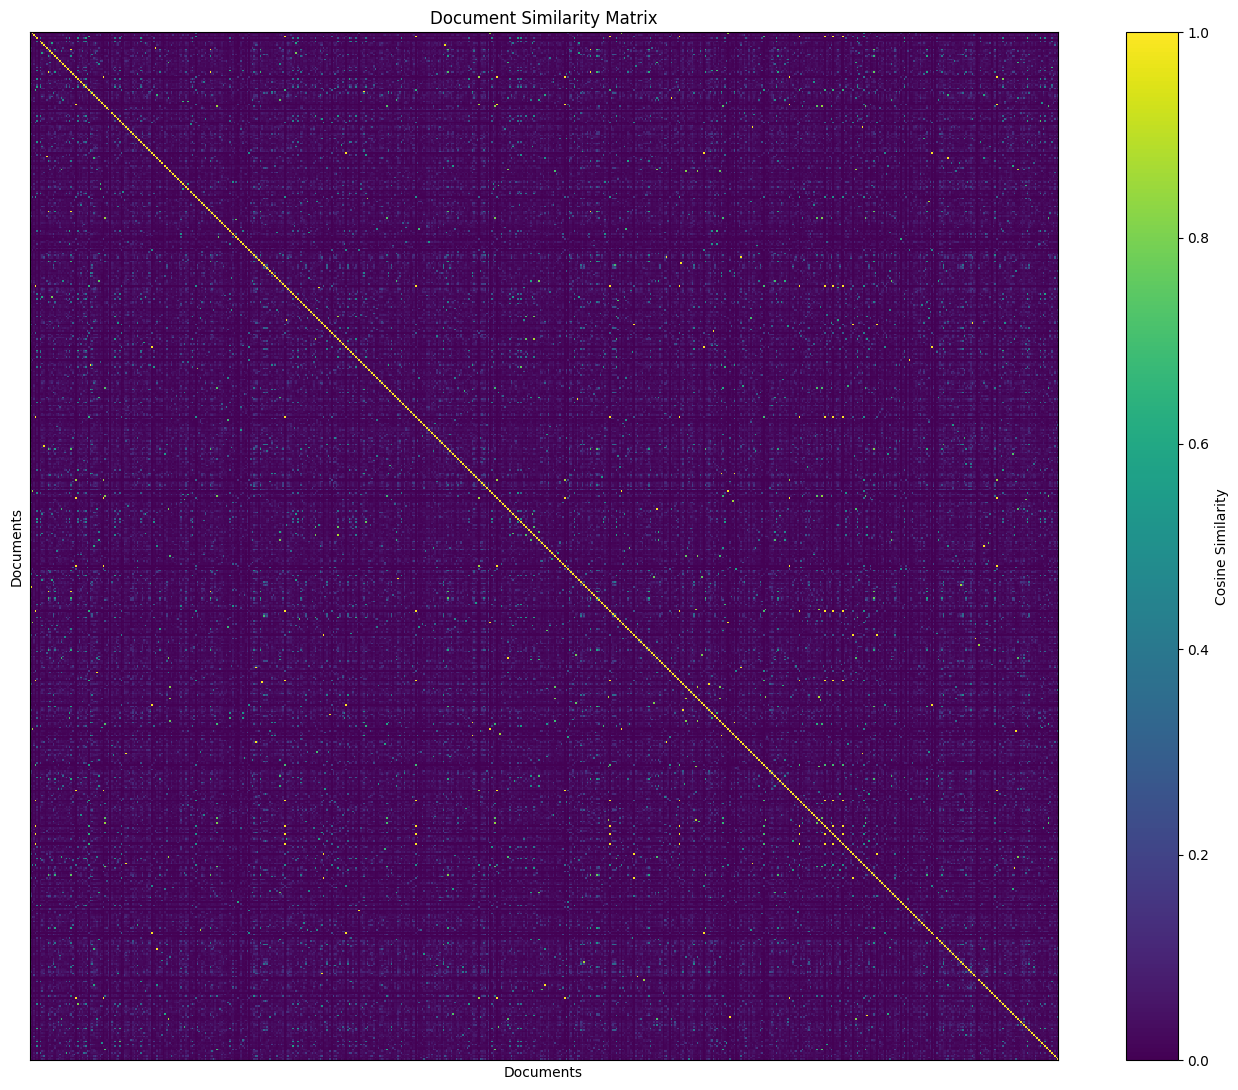

In [39]:
MBG_similarity_matrix = similarity_matrix(MBG_tf_idf)

print(MBG_similarity_matrix)

plot_similarity_matrix(MBG_similarity_matrix)

###### For Wikipedia

https://en.wikipedia.org/wiki/Ernest_Hemingway  \
https://en.wikipedia.org/wiki/Ernest_Hemingway                                        1.000000   
https://en.wikipedia.org/wiki/Microfiber                                              0.003895   
https://en.wikipedia.org/wiki/Data                                                    0.008186   
https://en.wikipedia.org/wiki/Electric_bus                                            0.004466   
https://en.wikipedia.org/wiki/Driving                                                 0.015004   
...                                                                                        ...   
https://en.wikipedia.org/wiki/Parasailing                                             0.011173   
https://en.wikipedia.org/wiki/Mary_Seacole                                            0.059434   
https://en.wikipedia.org/wiki/Canning                                                 0.010113   
https://en.wikipedia.org/wiki/Union_Jack                                              0.009532   
https://en.wikipedia.org/wiki/Running                                                 0.018126   

                                                https://en.wikipedia.org/wiki/Microfiber  \
https://en.wikipedia.org/wiki/Ernest_Hemingway                                  0.003895   
https://en.wikipedia.org/wiki/Microfiber                                        1.000000   
https://en.wikipedia.org/wiki/Data                                              0.006644   
https://en.wikipedia.org/wiki/Electric_bus                                      0.003761   
https://en.wikipedia.org/wiki/Driving                                           0.006217   
...                                                                                  ...   
https://en.wikipedia.org/wiki/Parasailing                                       0.006928   
https://en.wikipedia.org/wiki/Mary_Seacole                                      0.007700   
https://en.wikipedia.org/wiki/Canning                                           0.009412   
https://en.wikipedia.org/wiki/Union_Jack                                        0.003385   
https://en.wikipedia.org/wiki/Running                                           0.009866   

                                                https://en.wikipedia.org/wiki/Data  \
https://en.wikipedia.org/wiki/Ernest_Hemingway                            0.008186   
https://en.wikipedia.org/wiki/Microfiber                                  0.006644   
https://en.wikipedia.org/wiki/Data                                        1.000000   
https://en.wikipedia.org/wiki/Electric_bus                                0.003797   
https://en.wikipedia.org/wiki/Driving                                     0.019887   
...                                                                            ...   
https://en.wikipedia.org/wiki/Parasailing                                 0.007508   
https://en.wikipedia.org/wiki/Mary_Seacole                                0.015387   
https://en.wikipedia.org/wiki/Canning                                     0.008047   
https://en.wikipedia.org/wiki/Union_Jack                                  0.005508   
https://en.wikipedia.org/wiki/Running                                     0.010339   

                                                https://en.wikipedia.org/wiki/Electric_bus  \
https://en.wikipedia.org/wiki/Ernest_Hemingway                                    0.004466   
https://en.wikipedia.org/wiki/Microfiber                                          0.003761   
https://en.wikipedia.org/wiki/Data                                                0.003797   
https://en.wikipedia.org/wiki/Electric_bus                                        1.000000   
https://en.wikipedia.org/wiki/Driving                                             0.055100   
...                                                                                    ...   
https://en.wikipedia.org/wiki/Parasailing                                  

                                                https://en.wikipedia.org/wiki/Ernest_Hemingway  \
https://en.wikipedia.org/wiki/Ernest_Hemingway                                        1.000000   
https://en.wikipedia.org/wiki/Microfiber                                              0.003895   
https://en.wikipedia.org/wiki/Data                                                    0.008186   
https://en.wikipedia.org/wiki/Electric_bus                                            0.004466   
https://en.wikipedia.org/wiki/Driving                                                 0.015004   
...                                                                                        ...   
https://en.wikipedia.org/wiki/Parasailing                                             0.011173   
https://en.wikipedia.org/wiki/Mary_Seacole                                            0.059434   
https://en.wikipedia.org/wiki/Canning                                                 0.010113   
https://en.wikipedia

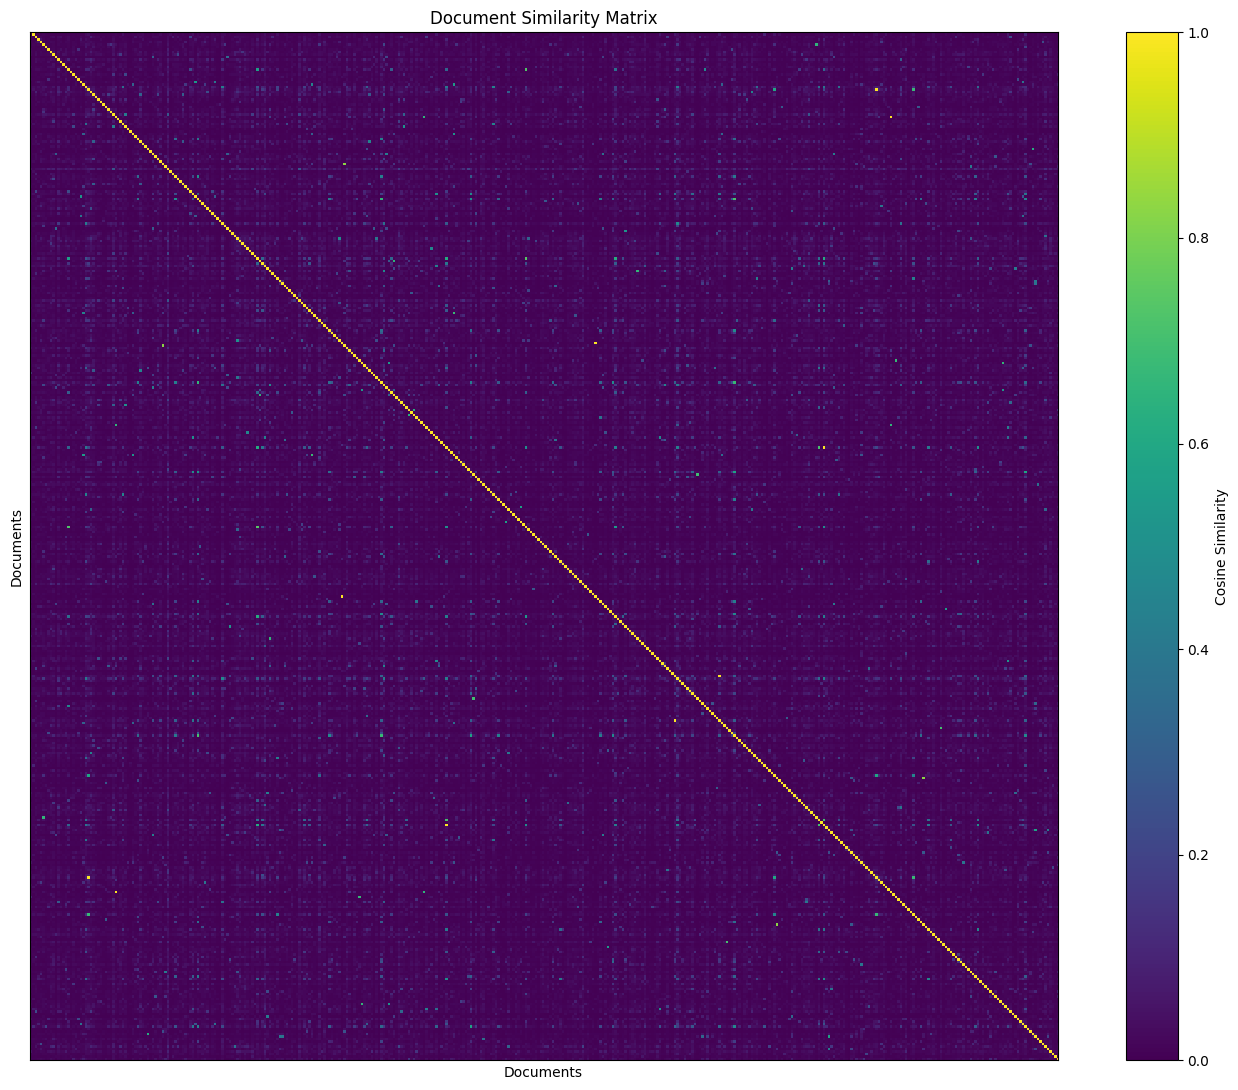

In [40]:
wiki_similarity_matrix = similarity_matrix(wiki_tf_idf)

print(wiki_similarity_matrix)

plot_similarity_matrix(wiki_similarity_matrix)

## Most frequent words

###### For MindBodyGreen

In [41]:
all_tokens = [tok for tokens in tokenized_MBG_csv["tokenized_text"] for tok in tokens]  # Create a list with all the tokens
MBG_word_freq = Counter(all_tokens)  # Count the number of times a token appears in the list
MBG_word_freq.most_common(20)  # Print only the 20 most frequent

[('health', 2091),
 ('skin', 1916),
 ('muscle', 1620),
 ('sleep', 1329),
 ('food', 1327),
 ('protein', 1261),
 ('need', 1075),
 ('product', 1064),
 ('support', 1046),
 ('may', 945),
 ('people', 896),
 ('exercise', 892),
 ('disease', 886),
 ('feel', 865),
 ('supplement', 853),
 ('best', 818),
 ('benefit', 818),
 ('brain', 807),
 ('level', 794),
 ('strength', 782)]

###### For Wikipedia

In [42]:
all_tokens = [tok for tokens in tokenized_wiki_csv["tokenized_text"] for tok in tokens]  # Create a list with all the tokens
wiki_word_freq = Counter(all_tokens)  # Count the number of times a token appears in the list
wiki_word_freq.most_common(20)  # Print only the 20 most frequent

[('water', 3140),
 ('may', 3065),
 ('state', 2993),
 ('energy', 2979),
 ('world', 2710),
 ('system', 2629),
 ('century', 2171),
 ('people', 2119),
 ('country', 2103),
 ('th', 2077),
 ('city', 1943),
 ('fashion', 1785),
 ('high', 1737),
 ('united', 1717),
 ('including', 1716),
 ('product', 1714),
 ('material', 1677),
 ('power', 1671),
 ('include', 1660),
 ('form', 1637)]

## Words cloud

#### Definitions implementation

In [15]:
def plot_wordcloud(word_freq, title):
    
    wc = WordCloud(width=900, height=450, background_color="white").generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=15, pad=20) # Ajout d'un titre pour ne pas les confondre
    plt.show()

#### Execution

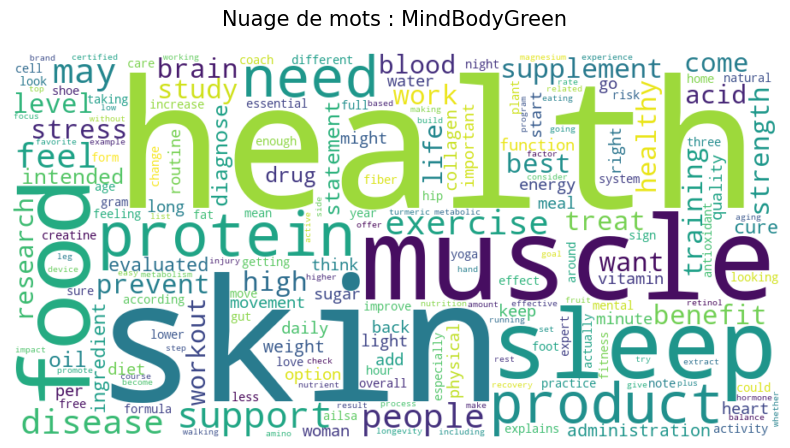

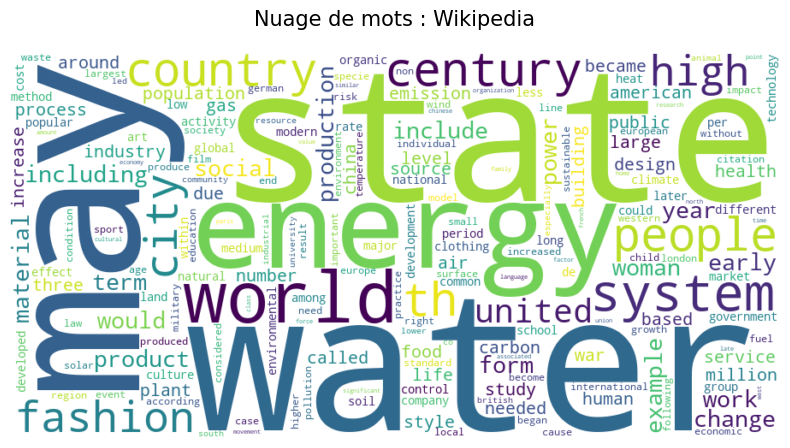

In [44]:
plot_wordcloud(MBG_word_freq, "Nuage de mots : MindBodyGreen")
plot_wordcloud(wiki_word_freq, "Nuage de mots : Wikipedia")

## Analyse thématique MBG

In [45]:
MBG_tf_idf_clean = MBG_tf_idf.replace([np.inf, -np.inf], np.nan).fillna(0)
# Cleaning TF-IDF: replace infinite values with NaN, then replace NaN with 0
# Essential because some operations (e.g., divisions) can produce inf/-inf, and many algos crash with NaN

In [46]:
def plot_elbow(tf_idf, max_k=10):
    
    inertias = [] # List to store inertia (SSE) for each k
    n_docs = tf_idf.shape[0] # Number of documents (= number of rows)
    max_k = min(max_k, n_docs - 1) # Safety check: k cannot exceed n_docs-1
    K_values = range(2, max_k) # Avoiding test if k=1

    for k in K_values: # Loop over k values to train KMeans and retrieve inertia
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tf_idf)
        inertias.append(kmeans.inertia_) # Inertia = sum of intra-cluster distances

    plt.figure(figsize=(8,5))
    plt.plot(K_values, inertias, marker='o') 
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Inertia (distortion)")
    plt.title("Méthode du coude (Elbow Method)")
    plt.grid(True)
    plt.show()

    # Heuristic to approximate the "knee":
    # we look for the point with the largest successive "drop" in inertia
    deltas = np.diff(inertias)
    best_k_idx = np.argmin(deltas) + 1 # index of the "biggest drop" (most negative) +1 because diff shifts by 1
    best_k = K_values[best_k_idx]
    best_inertia = inertias[best_k_idx]

    return best_k, best_inertia, K_values, inertias


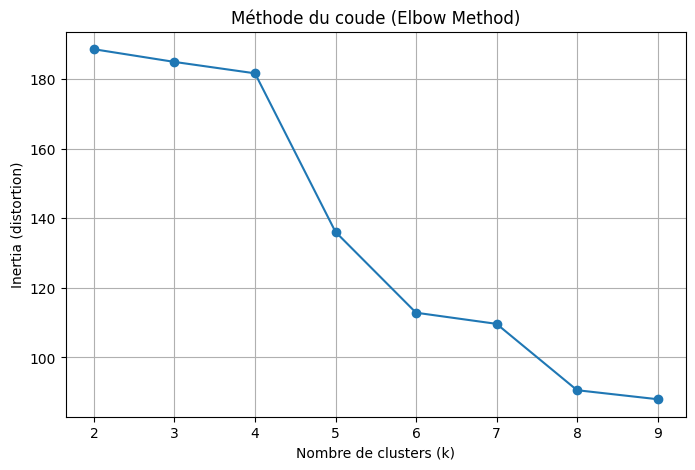

Best k : 5
Associated inertia : 136.0587137402641


In [47]:
best_k, best_inertia, K_values, inertias = plot_elbow(MBG_tf_idf_clean, max_k=10)
print("Best k :", best_k)
print("Associated inertia :", best_inertia)

In [48]:
def plot_silhouette(tf_idf, max_k=10):
    
    scores = []
    n_docs = tf_idf.shape[0]
    max_k = min(max_k, n_docs - 1)
    K_values = range(2, max_k)

    for k in K_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(tf_idf) # Fits and returns the cluster assigned to each doc
        score = silhouette_score(tf_idf, labels) # Measures separation vs compactness (higher = better)
        scores.append(score)

    plt.figure(figsize=(8,5))
    plt.plot(K_values, scores, marker='o')
    plt.xlabel("k")
    plt.ylabel("Silhouette score")
    plt.title("Méthode du Silhouette Score")
    plt.grid(True)
    plt.show()

    best_score = max(scores) # Select the best k: the one that maximizes the silhouette score
    best_k = K_values[scores.index(best_score)] 
    
    return best_k, best_score, list(K_values), scores

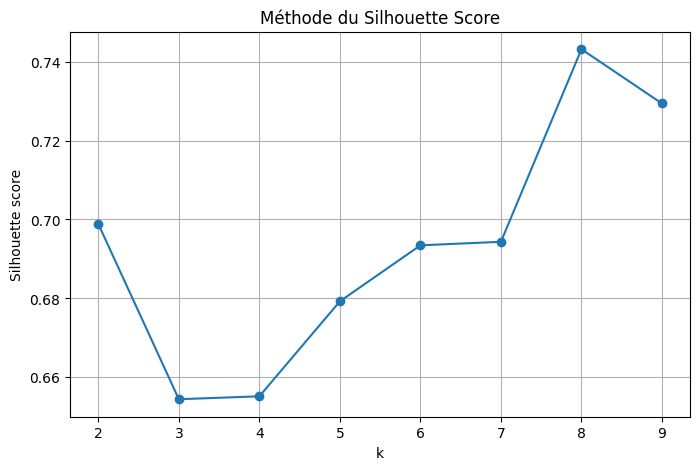

Best k : 8
Associated silhouette score : 0.743157546454118


In [49]:
best_k, best_score, ks, scores = plot_silhouette(MBG_tf_idf_clean) 

print("Best k :", best_k) 
print("Associated silhouette score :", best_score)

Attention : on prend 5 pour k et pas 4 parce que les clusters sont mesurés sur base de tokens (= pas de stopwords ou custom_stopwords) sauf que Bert est sur normalized_text et même si on prend dans vectorizer les stopwords, Bert ne les exclut pas donc on prend k+1 car un cluster sera pour les noms.

In [141]:
MBG_k = 4
MBG_kmeans = KMeans(n_clusters=MBG_k, random_state=42)
MBG_tf_idf_clean['cluster'] = MBG_kmeans.fit_predict(MBG_tf_idf_clean)

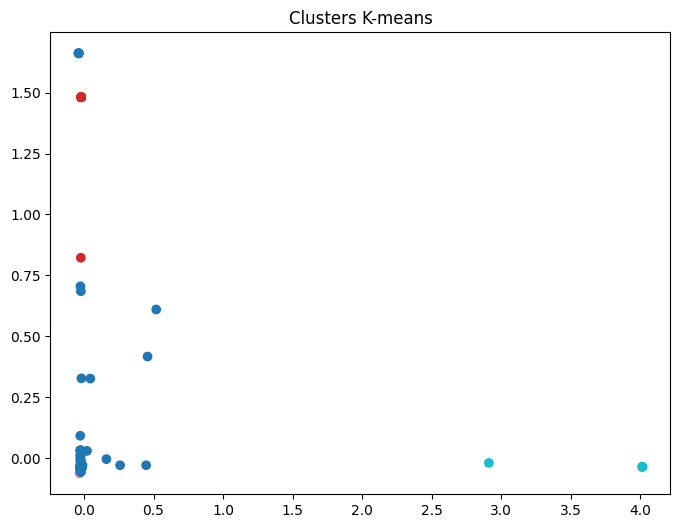

In [142]:
pca = PCA(n_components=2)
coords = pca.fit_transform(MBG_tf_idf_clean.drop(columns=['cluster']))

MBG_pca_df = pd.DataFrame(coords, columns=['x','y'], index=MBG_tf_idf_clean.index)

plt.figure(figsize=(8,6)) 
plt.scatter(MBG_pca_df['x'], MBG_pca_df['y'], c=MBG_tf_idf_clean['cluster'], cmap='tab10') 
plt.title("Clusters K-means") 
plt.show()

## Bertopic model

#### Definitions implementation

In [ ]:
def bertopic_hdbscan(normalized_corpus, min_words=30, embedding_model_name="all-MiniLM-L6-v2", nr_words=20, min_df=2, max_df=0.8, stop_words=None):
    # Load corpus
    df = pd.read_csv(normalized_corpus)
    documents = df["normalized_text"].astype(str).tolist()

    # Remove short documents
    documents = [d for d in documents if len(d.split()) >= min_words]

    # Embedding model
    embedding_model = SentenceTransformer(embedding_model_name)

    # Vectorizer
    vectorizer_model = CountVectorizer(
        stop_words=stop_words,
        min_df=min_df,
        max_df=max_df,
        max_features=5000
    )

    # Representation model
    representation_model = KeyBERTInspired(top_n_words=nr_words)

    # HDBSCAN clustering
    hdbscan_model = HDBSCAN(
        min_cluster_size=15,
        metric='euclidean',
        cluster_selection_method='eom'
    )

    # BERTopic model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        hdbscan_model=hdbscan_model,
        representation_model=representation_model,
        verbose=True
    )

    # Fit + transform
    topics, probs = topic_model.fit_transform(documents)

    return topic_model, topics, probs, documents

#### Execution

###### For MindBodyGreen

In [51]:
MBG_bert, MBG_topics, MBG_probs, MBG_docs = bertopic_hdbscan("data/MBG_normalized_corpus.csv", min_words=50, nr_words=100, min_df=2, max_df=0.8, stop_words=list(ALL_STOPWORDS))

2026-01-06 00:17:41,535 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]
2026-01-06 00:18:15,682 - BERTopic - Embedding - Completed ✓
2026-01-06 00:18:15,683 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-06 00:18:38,820 - BERTopic - Dimensionality - Completed ✓
2026-01-06 00:18:38,823 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-06 00:18:38,873 - BERTopic - Cluster - Completed ✓
2026-01-06 00:18:38,884 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-06 00:18:42,235 - BERTopic - Representation - Completed ✓


###### For Wikipedia

In [40]:
wiki_bert, wiki_topics, wiki_probs, wiki_docs = bertopic_hdbscan( "data/wiki_normalized_corpus.csv", min_words=50, nr_words=100, min_df=2, max_df=0.8, stop_words=list(ALL_STOPWORDS))

2026-01-06 18:11:57,048 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 13/13 [00:28<00:00,  2.23s/it]
2026-01-06 18:12:26,733 - BERTopic - Embedding - Completed ✓
2026-01-06 18:12:26,735 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-06 18:12:27,640 - BERTopic - Dimensionality - Completed ✓
2026-01-06 18:12:27,643 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-06 18:12:27,665 - BERTopic - Cluster - Completed ✓
2026-01-06 18:12:27,674 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-06 18:12:33,865 - BERTopic - Representation - Completed ✓


## Topic and main topic identification

#### Definitions implementation

In [17]:
def summarize_topics(topic_model, top_words=3, max_words=100, min_score=0.075):
    topic_info = topic_model.get_topic_info()  # Retrieve general information about topics (Topic ID, document count, name)
    topic_info = topic_info[topic_info.Topic != -1]  # Remove the outlier topic (-1), which BERTopic uses for noise

    # Identify the main topic: the one with the highest document count
    main_topic_id = (
        topic_info.sort_values(by="Count", ascending=False)  # Sort topics by number of documents
        .Topic   # Select the Topic column
        .iloc[0]  # Take the first (most frequent) topic
    )

    themes = {}  # Initialize dictionary that will store themes and their keywords
    
    for topic_id in topic_info.Topic:  # Loop through each topic ID
        words_scores = topic_model.get_topic(topic_id)  # Retrieve list of pairs (word and score) for the topic
        words = [ word for word, score in words_scores if score >= min_score][:max_words]  # Filter words by minimum score and limit total number of words

        theme_name = ", ".join(words[:top_words])  # Create a short theme name using the top (top_words) words
        count_docs = topic_info.loc[topic_info.Topic == topic_id, "Count"].values[0]  # Retrieve the number of documents associated with this topic
        is_main_topic = (topic_id == main_topic_id)  # Check whether this topic is the main topic
        themes[theme_name] = {"keywords": words}  # Store keywords for this theme in the dictionary
        
        print(f"Theme: {theme_name}")                            
        print("Numbers of documents", count_docs)
        print(words)
        
        if is_main_topic:
            main_topic_words = words  # If this is the main topic, store its words separately
            print("-> This is the main topic")

        print("-" * 60)  # Help us visualize the result
        
# ATTENTION : voir si cette ligne est nécessaire ??
    topic_df = topic_info.copy()  # Create a copy of the topic information DataFrame to return
    
    return themes, main_topic_words, topic_df

In [73]:
def filter_topic_words(main_topic_words):
    filtered_words = []
    
    for word in main_topic_words :
        
        if len(word) <= 2 :
            continue
        
        if word in list(ALL_STOPWORDS) :
            continue
        
        filtered_words.append(word)
    return filtered_words

In [74]:
def datamuse_synonyms(word):
    synonyms = set()

    url_syn = f"https://api.datamuse.com/words?rel_syn={word}"  # Build the Datamuse API URL to request synonyms of the given word
    
    try:
        response = requests.get(url_syn, timeout=5).json()  # Send the request with a timeout and parse the JSON response
        
        for item in response:  # Iterate through each returned item (each potential synonym)
            
            if item.get("score", 0) > 500:  # Keep only synonyms with a high relevance score (> 500)
                synonyms.add(item["word"])  # Add the synonym to the set
    
    except Exception:
        pass  # Ignore any network or parsing errors

    return list(synonyms)

In [75]:
# Check whether the input string corresponds to a real, commonly used English word. 
# # The function uses the Zipf frequency score: higher values indicate more frequent words. 
# # A word is considered "real" if its Zipf score is above the given threshold.

def is_real_word(word, threshold=1.5):  # Verify if a word is a real word
    return zipf_frequency(word, "en") >= threshold

In [76]:
def expand_with_synonyms(word_list):

    expanded = set()

    for word in word_list:
        expanded.add(word.lower())  # Always keep the original word (no filtering applied here)
       
        for variant in [word + "s", word + "ing", word + "ed"]:
            expanded.add(variant)  # Add simple morphological variants of the original word

        syns = datamuse_synonyms(word)  # Retrieve synonyms for the current word

        for s in syns:  # Process and filter only the synonyms
            s = s.lower().strip()

            if is_real_word(s):  # Check if the synonyme is a real word
              
                if len(s) <= 2:  # Skip very short tokens
                    continue
              
                if s in list(ALL_STOPWORDS):  # Skip stopwords
                    continue
              
                if len(s.split()) > 1:  # Skip multi‑word expressions (keep only single tokens)
                    continue

                expanded.add(s)  # Add the cleaned synonym

                for variant in [s + "s", s + "ing", s + "ed"]:  # Add morphological variants of the synonym, but only if they are real words
                    if is_real_word(variant):
                        expanded.add(variant)

    return sorted(expanded)

#### Execution

In [77]:
MBG_themes, MBG_main_topic_words, MBG_topic_df = summarize_topics(MBG_bert, top_words=3)

Theme: yoga, techniques, benefits
Numbers of documents 125
['yoga', 'techniques', 'benefits', 'therapy', 'mindfulness', 'experiences', 'stressful', 'sedentary', 'nervous', 'technique', 'meditation', 'ease', 'supporting', 'dopamine', 'calming', 'anxiety', 'grounding', 'cortisol', 'supplement', 'depression', 'anxious', 'resilience', 'chakra', 'emotions', 'findings', 'nootropic', 'awareness', 'researchers', 'podcast', 'dementia', 'thoughts', 'breathwork', 'alzheimer', 'critical', 'burnout', 'cognitive', 'breathing', 'social', 'habit', 'spike', 'boundaries', 'listening', 'emotionally', 'restorative', 'feelings', 'effect', 'connection', 'mindset', 'compassion', 'flow', 'lower', 'mood', 'sugar', 'positive', 'participants', 'poses', 'symptoms']
-> This is the main topic
------------------------------------------------------------
Theme: supplement, protein, nutrients
Numbers of documents 81
['supplement', 'protein', 'nutrients', 'nutrient', 'dietary', 'metabolic', 'metabolism', 'diets', 'prot

In [41]:
wiki_themes, wiki_main_topic_words, wiki_topic_df = summarize_topics(wiki_bert, top_words=3)

Theme: irrigation, deforestation, planting
Numbers of documents 103
['irrigation', 'deforestation', 'planting', 'soils', 'crop', 'ecology', 'fertilizers', 'ecosystems', 'biomass', 'fertilizer', 'geothermal', 'groundwater', 'runoff', 'biogas', 'turbines', 'microorganisms', 'shower', 'renewables', 'generators', 'biofuels', 'biofuel', 'mulch', 'turbine', 'evaporation', 'renewable', 'microbial', 'manure', 'rainwater', 'conservation', 'generator', 'wastewater', 'degradation', 'grilling', 'pests', 'pumps', 'fuels', 'bacteria', 'yield', 'decomposition', 'nutrient', 'anaerobic', 'glazing', 'landfills', 'pesticides']
-> This is the main topic
------------------------------------------------------------
Theme: disciplines, tube, amusement
Numbers of documents 103
['disciplines', 'tube', 'amusement', 'cells', 'pill', 'races', 'championships', 'hr', 'buoyancy', 'bike', 'zebra', 'participants']
------------------------------------------------------------
Theme: tao, sociology, yoga
Numbers of docum

In [78]:
MBG_main_topic_words_filtered = filter_topic_words(MBG_main_topic_words)
print(len(MBG_main_topic_words_filtered), "keywords was found for the main topic :", MBG_main_topic_words[:3])
print("Here are the original keywords :", MBG_main_topic_words_filtered)

MBG_expanded_keywords = expand_with_synonyms(MBG_main_topic_words)
print("We enlarged the keywords and now have a list of", len(MBG_expanded_keywords), "keywords")

57 keywords was found for the main topic : ['yoga', 'techniques', 'benefits']
Here are the original keywords : ['yoga', 'techniques', 'benefits', 'therapy', 'mindfulness', 'experiences', 'stressful', 'sedentary', 'nervous', 'technique', 'meditation', 'ease', 'supporting', 'dopamine', 'calming', 'anxiety', 'grounding', 'cortisol', 'supplement', 'depression', 'anxious', 'resilience', 'chakra', 'emotions', 'findings', 'nootropic', 'awareness', 'researchers', 'podcast', 'dementia', 'thoughts', 'breathwork', 'alzheimer', 'critical', 'burnout', 'cognitive', 'breathing', 'social', 'habit', 'spike', 'boundaries', 'listening', 'emotionally', 'restorative', 'feelings', 'effect', 'connection', 'mindset', 'compassion', 'flow', 'lower', 'mood', 'sugar', 'positive', 'participants', 'poses', 'symptoms']
We enlarged the keywords and now have a list of 519 keywords


In [81]:
# Créer un DataFrame
df = pd.DataFrame({"main_topic_words_filtered": [MBG_expanded_keywords]}) # note les [ ] pour que ce soit UNE cellule

# Sauvegarder
df.to_csv("data/main_topic_words_filtered.csv", index=False)
print("The final list of words is saved in a file called : main_topic_words.csv")

The final list of words is saved in a file called : main_topic_words.csv


# Text mining of Feedspot

#### Preprocessing, Normalization, and Tokenization

In [31]:
df = pd.read_csv("data/feedspot_seed_blogs.csv") 
blogs_domain = ast.literal_eval(df["seed_blogs"].iloc[0])

In [32]:
content_date_blogs_csv = content_date_csv_file("data/blogs_raw_html.csv", "data/blogs_content_date.csv", domain=blogs_domain)
corpus_blogs_csv = corpus_csv_file("data/blogs_content_date.csv", "data/blogs_corpus.csv")
cleaned_blogs_csv = clean_csv_file("data/blogs_corpus.csv", "data/blogs_cleaned_corpus.csv")
normalized_blogs_csv = normalize_csv_file("data/blogs_cleaned_corpus.csv", "data/blogs_normalized_corpus.csv")
tokenized_blogs_csv = tokenize_csv_file("data/blogs_normalized_corpus.csv", "data/blogs_tokenized_corpus.csv")

In [10]:
print(len(corpus_blogs_csv), "documents were collected for Feedspot")

1068 documents were collected for Feedspot


#### Term document matrix

In [33]:
print("\n=== BUILDING TERM-DOCUMENT MATRIX FOR FEEDSPOT ===")

blogs_min_doc_freq = len(tokenized_blogs_csv)*0.01
blogs_max_doc_freq = len(tokenized_blogs_csv)*0.6

blogs_tokenized_dict = dict(zip(tokenized_blogs_csv['url'], tokenized_blogs_csv['tokenized_text']))  # We transform the csv file with the tokenized text into a dictionnary to make it feet the function above seen in class
blogs_td_matrix, blogs_vocab = build_term_document_matrix(blogs_tokenized_dict, min_doc_freq=blogs_min_doc_freq, max_doc_freq=blogs_max_doc_freq)

print(blogs_vocab[:20])
print(blogs_td_matrix)


=== BUILDING TERM-DOCUMENT MATRIX FOR FEEDSPOT ===
['treatment', 'maker', 'cider', 'scene', 'may', 'protein', 'current', 'glow', 'caslon', 'velcro', 'drive', 'sparkling', 'student', 'printable', 'cozy', 'iron', 'morning', 'mail', 'mom', 'photo']
                                                    treatment  maker  cider  \
https://40plusstyle.com/best-winter-gloves-for-...          0      0      0   
https://40plusstyle.com/womens-beach-outfits/               0      0      0   
https://40plusstyle.com/fall-womens-sneakers/               0      0      0   
https://40plusstyle.com/bb-cream-reviews-of-bob...          0      0      0   
https://40plusstyle.com/how-to-wear-capris-and-...          0      0      0   
...                                                       ...    ...    ...   
https://www.wisconsinmommy.com/hidden-restauran...          0      0      0   
https://www.wisconsinmommy.com/halloween-craft/             0      0      0   
https://www.wisconsinmommy.com/seven-spook

#### TF-IDF

In [34]:
blogs_tf_idf = tf_idf(blogs_td_matrix)
print(blogs_tf_idf)

                                                    treatment  maker  cider  \
https://40plusstyle.com/best-winter-gloves-for-...        0.0    0.0    0.0   
https://40plusstyle.com/womens-beach-outfits/             0.0    0.0    0.0   
https://40plusstyle.com/fall-womens-sneakers/             0.0    0.0    0.0   
https://40plusstyle.com/bb-cream-reviews-of-bob...        0.0    0.0    0.0   
https://40plusstyle.com/how-to-wear-capris-and-...        0.0    0.0    0.0   
...                                                       ...    ...    ...   
https://www.wisconsinmommy.com/hidden-restauran...        0.0    0.0    0.0   
https://www.wisconsinmommy.com/halloween-craft/           0.0    0.0    0.0   
https://www.wisconsinmommy.com/seven-spooky-pla...        0.0    0.0    0.0   
https://www.wovenbywords.com/2025/11/love-on-ru...        0.0    0.0    0.0   
https://www.wovenbywords.com/2025/12/every-voic...        0.0    0.0    0.0   

                                                   

#### Similarity matrix

https://40plusstyle.com/best-winter-gloves-for-women/  \
https://40plusstyle.com/best-winter-gloves-for-...                                           1.000000       
https://40plusstyle.com/womens-beach-outfits/                                                0.052563       
https://40plusstyle.com/fall-womens-sneakers/                                                0.077251       
https://40plusstyle.com/bb-cream-reviews-of-bob...                                           0.022299       
https://40plusstyle.com/how-to-wear-capris-and-...                                           0.042030       
...                                                                                               ...       
https://www.wisconsinmommy.com/hidden-restauran...                                           0.007934       
https://www.wisconsinmommy.com/halloween-craft/                                              0.008758       
https://www.wisconsinmommy.com/seven-spooky-pla...                                           0.005273       
https://www.wovenbywords.com/2025/11/love-on-ru...                                           0.010091       
https://www.wovenbywords.com/2025/12/every-voic...                                           0.010767       

                                                    https://40plusstyle.com/womens-beach-outfits/  \
https://40plusstyle.com/best-winter-gloves-for-...                                       0.052563   
https://40plusstyle.com/womens-beach-outfits/                                            1.000000   
https://40plusstyle.com/fall-womens-sneakers/                                            0.091553   
https://40plusstyle.com/bb-cream-reviews-of-bob...                                       0.038490   
https://40plusstyle.com/how-to-wear-capris-and-...                                       0.171015   
...                                                                                           ...   
https://www.wisconsinmommy.com/hidden-restauran...                                       0.023711   
https://www.wisconsinmommy.com/halloween-craft/                                          0.022052   
https://www.wisconsinmommy.com/seven-spooky-pla...                                       0.006175   
https://www.wovenbywords.com/2025/11/love-on-ru...                                       0.015471   
https://www.wovenbywords.com/2025/12/every-voic...                                       0.034856   

                                                    https://40plusstyle.com/fall-womens-sneakers/  \
https://40plusstyle.com/best-winter-gloves-for-...                                       0.077251   
https://40plusstyle.com/womens-beach-outfits/                                            0.091553   
https://40plusstyle.com/fall-womens-sneakers/                                            1.000000   
https://40plusstyle.com/bb-cream-reviews-of-bob...                                       0.031252   
https://40plusstyle.com/how-to-wear-capris-and-...                                       0.116646   
...                                                                                           ...   
https://www.wisconsinmommy.com/hidden-restauran...                                       0.025099   
https://www.wisconsinmommy.com/halloween-craft/                                          0.015590   
https://www.wisconsinmommy.com/seven-spooky-pla...                                       0.008965   
https://www.wovenbywords.com/2025/11/love-on-ru...                                       0.029457   
https://www.wovenbywords.com/2025/12/every-voic...                                       0.012273   

                                                    https://40plusstyle.com/bb-cream-reviews-of-bobbi-brown-la-roche-posay-ginvera/  \
https://40plusstyle.com/best-winter-gloves-for-...                                           0.022299                                 
https://40plusstyle.com/womens-beach-outfits/  

                                                    https://40plusstyle.com/best-winter-gloves-for-women/  \
https://40plusstyle.com/best-winter-gloves-for-...                                           1.000000       
https://40plusstyle.com/womens-beach-outfits/                                                0.052563       
https://40plusstyle.com/fall-womens-sneakers/                                                0.077251       
https://40plusstyle.com/bb-cream-reviews-of-bob...                                           0.022299       
https://40plusstyle.com/how-to-wear-capris-and-...                                           0.042030       
...                                                                                               ...       
https://www.wisconsinmommy.com/hidden-restauran...                                           0.007934       
https://www.wisconsinmommy.com/halloween-craft/                                              0.008758       
https://www.wiscons

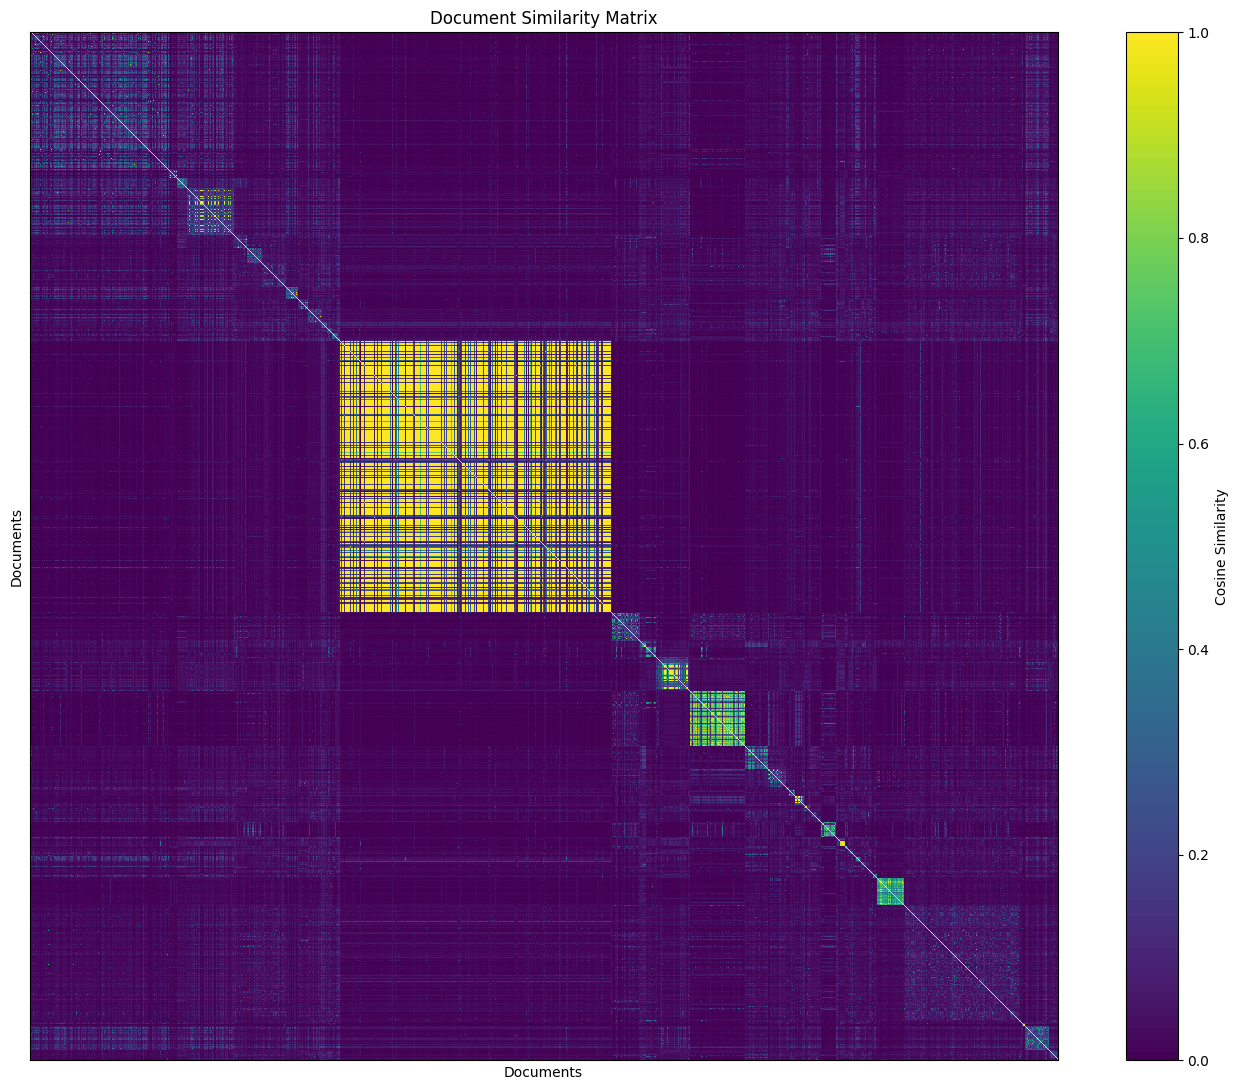

In [35]:
blogs_similarity_matrix = similarity_matrix(blogs_tf_idf)

print(blogs_similarity_matrix)

plot_similarity_matrix(blogs_similarity_matrix)

In [36]:
threshold = 0.9  
blogs_similar_pairs = np.argwhere((blogs_similarity_matrix > threshold) & (blogs_similarity_matrix < 1.0))

unique_docs = np.unique(blogs_similar_pairs)

print("Number of documents in the yellow box above :", len(unique_docs))

Number of documents in the yellow box above : 409


In [37]:
urls = tokenized_blogs_csv['url'].iloc[unique_docs].tolist()

domains = [urlparse(u).netloc for u in urls]
domain_counts = Counter(domains)

print("\nThe document in the yellow box are coming from these blogs :")
for dom, count in domain_counts.most_common(10):
    print(f"{dom}: {count}")




The document in the yellow box are coming from these blogs :
40plusstyle.com: 66
www.theskinnyconfidential.com: 53
princesspinkygirl.com: 43
hisugarplum.com: 38
julieblanner.com: 17
awellstyledlife.com: 15
silverspoonlondon.co.uk: 14
www.themarthablog.com: 13
livinginyellow.com: 11
www.wardrobeoxygen.com: 10


#### Bert model and main topic

In [39]:
blogs_bert, blogs_topics, blogs_probs, blogs_docs = bertopic_hdbscan("data/blogs_normalized_corpus.csv", min_words=50, nr_words=100, min_df=2, max_df=0.8, stop_words=list(ALL_STOPWORDS))

2026-01-06 18:00:44,125 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]
2026-01-06 18:01:38,976 - BERTopic - Embedding - Completed ✓
2026-01-06 18:01:38,977 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-06 18:02:06,572 - BERTopic - Dimensionality - Completed ✓
2026-01-06 18:02:06,575 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-06 18:02:06,640 - BERTopic - Cluster - Completed ✓
2026-01-06 18:02:06,650 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-06 18:02:09,593 - BERTopic - Representation - Completed ✓


In [42]:
blogs_themes, blogs_main_topic_words, blogs_topic_df = summarize_topics(blogs_bert, top_words=3, max_words=100, min_score=0.05)

Theme: cream, tips, skin
Numbers of documents 413
['cream', 'tips', 'skin', 'shop', 'beauty', 'natural', 'hair', 'products', 'skinny', 'fresh', 'look', 'ingredients', 'going', 'healthy', 'travel', 'go', 'home', 'fall', 'start', 'brunch', 'night', 'friendly', 'thank', 'sugar', 'keep', 'everything', 'thanks', 'beautiful', 'add', 'getting', 'website', 'recipes', 'post', 'oil', 'check', 'small', 'perfect']
-> This is the main topic
------------------------------------------------------------
Theme: dresses, dress, outfits
Numbers of documents 236
['dresses', 'dress', 'outfits', 'outfit', 'wear', 'wearing', 'jeans', 'clothes', 'fashion', 'wardrobe', 'pants', 'leggings', 'styles', 'skirt', 'sneakers', 'waist', 'denim', 'sandals', 'shoes', 'heels', 'sweater', 'comfortable', 'jacket', 'style', 'stylish', 'fit', 'boots', 'shoe', 'shirt', 'scarf', 'nordstrom', 'shop', 'brands', 'leather', 'comfort', 'trend', 'shape', 'bag', 'earrings', 'blazer', 'fall', 'coat', 'women', 'pair', 'colors', 'look',

#### Temporality analysis

In [65]:
blogs_tf_idf_clean = blogs_tf_idf.replace([np.inf, -np.inf], np.nan).fillna(0)
# Cleaning TF-IDF: replace infinite values with NaN, then replace NaN with 0
# Essential because some operations (e.g., divisions) can produce inf/-inf, and many algos crash with NaN

In [68]:
def plot_elbow(tf_idf, max_k=10):
    
    inertias = [] # List to store inertia (SSE) for each k
    n_docs = tf_idf.shape[0] # Number of documents (= number of rows)
    max_k = min(max_k, n_docs - 1) # Safety check: k cannot exceed n_docs-1
    K_values = range(2, max_k) # Avoiding test if k=1

    for k in K_values: # Loop over k values to train KMeans and retrieve inertia
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tf_idf)
        inertias.append(kmeans.inertia_) # Inertia = sum of intra-cluster distances

    plt.figure(figsize=(8,5))
    plt.plot(K_values, inertias, marker='o') 
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Inertia (distortion)")
    plt.title("Méthode du coude (Elbow Method)")
    plt.grid(True)
    plt.show()

    # Heuristic to approximate the "knee":
    # we look for the point with the largest successive "drop" in inertia
    deltas = np.diff(inertias)
    best_k_idx = np.argmin(deltas) + 1 # index of the "biggest drop" (most negative) +1 because diff shifts by 1
    best_k = K_values[best_k_idx]
    best_inertia = inertias[best_k_idx]

    return best_k, best_inertia, K_values, inertias

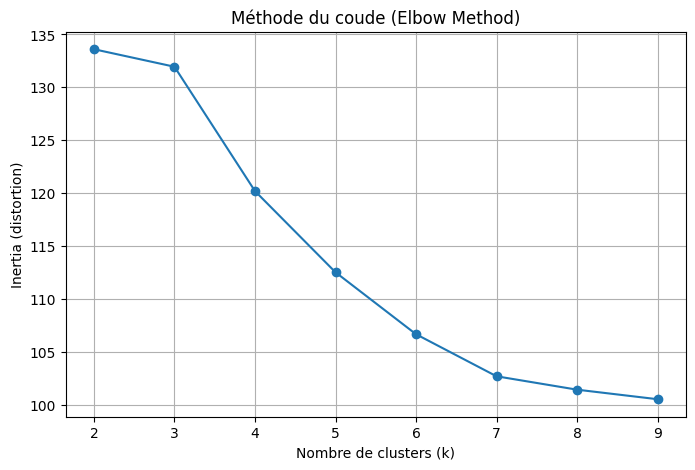

Best k : 4
Associated inertia : 120.19934003389615


In [69]:
best_k, best_inertia, K_values, inertias = plot_elbow(blogs_tf_idf_clean, max_k=10)
print("Best k :", best_k)
print("Associated inertia :", best_inertia)

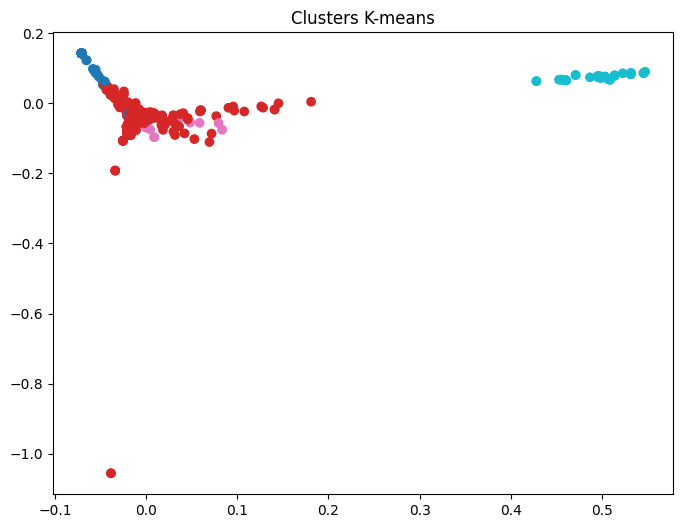

In [81]:
pca = PCA(n_components=2)
coords = pca.fit_transform(blogs_tf_idf_clean.drop(columns=['cluster']))

blogs_pca_df = pd.DataFrame(coords, columns=['x','y'], index=blogs_tf_idf_clean.index)

plt.figure(figsize=(8,6)) 
plt.scatter(blogs_pca_df['x'], blogs_pca_df['y'], c=blogs_tf_idf_clean['cluster'], cmap='tab10') 
plt.title("Clusters K-means") 
plt.show()

In [56]:
timeline_blogs = tokenized_blogs_csv.copy() # To be safer, we creat a copy of the dataframe
timeline_blogs['date'] = pd.to_datetime(timeline_blogs['date'], errors='coerce') # Transforms the dates into correct dates frame and if the data is not convertible it becomes "Not a Time"
timeline_blogs = timeline_blogs.dropna(subset=['date'])  # Remove rows with unvalid dates

In [58]:
def count_themes(tokens, themes): 
    # Count the number of times a theme (or associated word) appears in each document (/ doc's tokens)  
    counts = Counter()
    
    for theme, keyword in themes.items():
        keyword_set = set(keyword["keywords"])
        counts[theme] = sum(1 for token in tokens if token in keyword_set)
    
    return counts

In [ ]:
rows = []

for _, row in timeline_blogs.iterrows():
    tokens = row['tokenized_text']
    theme_counts = count_themes(tokens, blogs_themes)

    for theme, count in theme_counts.items():
        rows.append({
            "date": row['date'],
            "theme": theme,
            "count": count})

theme_timeline_blogs = pd.DataFrame(rows)

In [61]:
import ast
#timeline_blogs['tokenized_text'] = timeline_blogs['tokenized_text'].apply(ast.literal_eval)

theme_timeline_blogs['date'] = pd.to_datetime(theme_timeline_blogs['date'], errors='coerce')
theme_timeline_blogs = theme_timeline_blogs.dropna(subset=['date'])

In [ ]:
mask = (theme_timeline_blogs['date'] >= '2022-01-01') & \
       (theme_timeline_blogs['date'] <= '2025-12-31')

monthly_counts = (
    theme_timeline_blogs[mask]
    .groupby([pd.Grouper(key='date', freq='M'), 'theme'])['count']
    .sum()
    .unstack(fill_value=0))

monthly_counts.columns.name = None

In [80]:
blogs_k = 4
blogs_kmeans = KMeans(n_clusters=blogs_k, random_state=42)
blogs_tf_idf_clean['cluster'] = blogs_kmeans.fit_predict(blogs_tf_idf_clean)

In [85]:
top_k_themes = monthly_counts.sum().nlargest(blogs_k).index

<Figure size 1200x600 with 0 Axes>

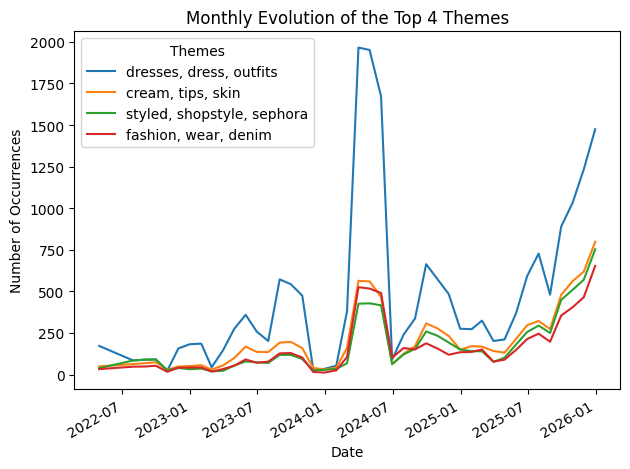

In [86]:
plt.figure(figsize=(12, 6))
monthly_counts[top_k_themes].rolling(window=3).mean().plot()
plt.title("Monthly Evolution of the Top 4 Themes")
plt.xlabel("Date")
plt.ylabel("Number of Occurrences")
plt.legend(title="Themes")
plt.tight_layout()
plt.show()

##### Preparation to the link analysis

In [82]:
def map_topics_to_csv(csv_path, documents, topics):
    df = pd.read_csv(csv_path)

    mapping = {doc: topic for doc, topic in zip(documents, topics)}  # Create a dictionary mapping each document to its corresponding topic

    df["topic"] = df["normalized_text"].apply(lambda txt: mapping.get(txt, "NA"))  # Assign a topic to each row based on the normalized_text column. If the text is not found in the mapping, assign "NA"

    return df[["url", "topic"]].rename(columns={"url": "node_id"})  # Return a DataFrame with selected columns, renaming "url" to "node_id"

In [83]:
blogs_nodes_topic = map_topics_to_csv( "data/blogs_normalized_corpus.csv", blogs_docs, blogs_topics)

blogs_nodes_topic.to_csv("data/blogs_nodes_topics.csv", index=False)